#### Eleonora Bellasio (15650A)
# <span style="color:orangered">Laboratorio di Simulazione Numerica: Esercitazione 10

### <span style="color:royalblue">Esercizio 10.1

Si vuole parallelizzare con la libreria MPI l'algoritmo genetico dell'esercitazione $9$ per risolvere il problema del commesso viaggiatore. L'obiettivo è effettuare una selezione genetica su 6 processi MPI che lavorano indipendentemente. Ogni processore esegue l'algoritmo genetico (continente) e cerca la soluzione ottimale. Il vantaggio della paralelizzazione è che il risultato che si ottiene con l'utilizzo di più core è migliore rispetto al risultato a cui si arriva utilizzandone uno solo.

Al codice dell'algoritmo genetico sono state apportate alcune modifiche per renderlo compatibile con la parallellizzaione, tra le più significative ci sono:
- Al costruttore della classe Popolazione viene passato il **rank** in modo da avere una popolazione di partenza differente per ogni processo;
- L'aggiunta della funzione **migrazione** che permette uno scambio tra continenti ogni $N_{migr}$ generazioni del miglior individuo in modo casuale;
- Il main contine **l'inizializzazione MPI** e indirizza gli output a seconda che si effettui calcolo in parallelo o seriale.

In questo esercizio si sono utilizzati i seguenti parametri per ricavare il miglior percorso tra città disposte casualmente sulla circonferenza e all'interno del quadrato:
- numero di individui = $200$ (nel caso seriale il numero di individui viene moltiplicato per il numero di processi per favorire il confronto)
- numero di generazioni = $600$
- $N_{migr} = 20 $
- probabilità di mutazione = $0.08$
- probabilità di crossover = $0.7$
- probabilità dell'algoritmo di selezione = $2.1$

In [26]:
import matplotlib.pyplot as plt
import numpy as np
import math
import os,sys
import pandas as pd

dinp = "10.1/OUTPUT/"

# === PARAMETRI ===
prefisso_file_C = "popolazione_C_"
estensione_file = ".dat"

df_C_ = {}
for i in range(0, 6):
    finp = dinp + prefisso_file_C + f'{i}' + estensione_file
    try:
        df_C_[f'{i}'] = pd.read_csv(finp, sep='\\s+', comment='#', names=['GENERAZIONE:','INDIVIDUO:','FITNESS:'])
    except FileNotFound:
        print(" file does not exist: " + finp )

prefisso_file_Q = "popolazione_Q_"
df_Q_ = {}
for i in range(0, 6):
    finp1 = dinp + prefisso_file_Q + f'{i}' + estensione_file
    try:
        df_Q_[F'{i}'] = pd.read_csv(finp1, sep='\\s+', comment='#', names=['GENERAZIONE:','INDIVIDUO:','FITNESS:'])
    except FileNotFound:
        print(" file does not exist: " + finp1 )

#definisco la funzione che stampa il valore della fitness migliore per ogni processo
def stampa_best_per_continente(best_values, geometry_type):
    print(f"\n{geometry_type.capitalize()}")
    for i, val in enumerate(best_values):
        if val is not None:
            print(f"Continent {i}: {val}")
        else:
            print(f"Continent {i}: N/A")

#Funzione che stampa la fitness del miglior continente
def trova_miglior_continente(best_values: list, geometry_type: str):
    # Filtra solo valori validi (non None)
    valori_validi = [(i, val) for i, val in enumerate(best_values) if val is not None]
    
    if not valori_validi:
        print(f"Nessun valore disponibile per geometria {geometry_type}")
        return None

    # Trova il minimo valore e il relativo indice
    miglior_continente, valore_minimo = min(valori_validi, key=lambda x: x[1])
    print(f"Continente con fitness minore (geometria {geometry_type}): Continent {miglior_continente} con valore: {valore_minimo}")
    return miglior_continente


#Calcolo la fitness migliore per ogni continente
best_C = []
best_Q = []

#Estraggo la fitness migliore per la geometria circolare
for i in range(0,6):
    if f'{i}' in df_C_:
        best_fitness = df_C_[f'{i}'].sort_values(by='FITNESS:')['FITNESS:'].iloc[0] #prendo la colonna i e cerco la fitness migliore
        best_C.append(best_fitness)
    else:
        best_C.append(None)

#Estraggo la fitness migliore per la geometria quadrata
for i in range(0,6):
    if f'{i}' in df_Q_:
        best_fitness = df_Q_[f'{i}'].sort_values(by='FITNESS:')['FITNESS:'].iloc[0]
        best_Q.append(best_fitness)
    else:
        best_Q.append(None)

#Stampo la fitness migliore per ciascun continente
stampa_best_per_continente(best_C, "circolare")
stampa_best_per_continente(best_Q, "quadrata")

#Stampo la fitness migliore tra tutti i continenti
miglior_continente_C = trova_miglior_continente(best_C, "circolare")
miglior_continente_Q = trova_miglior_continente(best_Q, "quadrata")



Circolare
Continent 0: 1.98328
Continent 1: 2.18846
Continent 2: 2.58018
Continent 3: 2.5189
Continent 4: 2.0231
Continent 5: 2.11915

Quadrata
Continent 0: 4.22468
Continent 1: 3.79897
Continent 2: 4.06825
Continent 3: 5.25323
Continent 4: 4.5061
Continent 5: 4.30743
Continente con fitness minore (geometria circolare): Continent 0 con valore: 1.98328
Continente con fitness minore (geometria quadrata): Continent 1 con valore: 3.79897


Ottenuti i due continenti con il risultato migliore per cerchio e quadrato, si produce un grafico del percorso migliore e uno della media dei $100$ migliori percorsi in funzione delle generazioni.

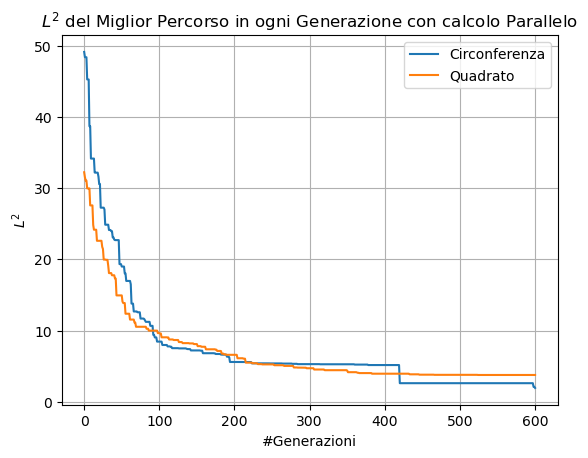

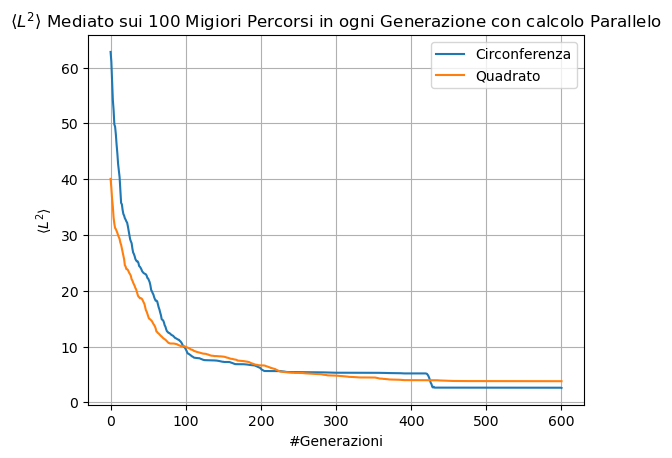

In [27]:
finp2 = dinp + prefisso_file_C + str(miglior_continente_C) + estensione_file
finp3 = dinp + prefisso_file_Q + str(miglior_continente_Q) + estensione_file

if not os.path.isfile(finp2):
    sys.exit( "file does not exist: " + finp2 )
if not os.path.isfile(finp3):
    sys.exit( "file does not exist: " + finp3 )

df_pop_C = pd.read_csv(finp2, sep='\\s+', comment='#', names=['GENERAZIONE:','INDIVIDUO:','FITNESS:'])
df_pop_Q = pd.read_csv(finp3, sep='\\s+', comment='#', names=['GENERAZIONE:','INDIVIDUO:','FITNESS:'])

df_best_C = df_pop_C[df_pop_C['INDIVIDUO:']==1]#scelgo i primi individui di ogni generazione
df_best_Q = df_pop_Q[df_pop_Q['INDIVIDUO:']==1]#che sono quelli migliori

#plt.figure()
plt.plot(df_best_C['GENERAZIONE:'], df_best_C['FITNESS:'], label = 'Circonferenza')
plt.plot(df_best_Q['GENERAZIONE:'], df_best_Q['FITNESS:'], label = 'Quadrato')
plt.xlabel('#Generazioni')
plt.ylabel(r'$L^{2}$')
plt.title(r'$L^{2}$ del Miglior Percorso in ogni Generazione con calcolo Parallelo')
plt.grid(True)

plt.legend()
plt.show()

media_C = []
media_Q = []

# Per Circonferenza
df_100_C = df_pop_C[df_pop_C['INDIVIDUO:'] <= 100]
media_C = df_100_C.groupby('GENERAZIONE:')['FITNESS:'].mean().values

# Per Quadrato
df_100_Q = df_pop_Q[df_pop_Q['INDIVIDUO:'] <= 100]
media_Q = df_100_Q.groupby('GENERAZIONE:')['FITNESS:'].mean().values

plt.plot(df_pop_C['GENERAZIONE:'].unique(), media_C, label='Circonferenza')
plt.plot(df_pop_Q['GENERAZIONE:'].unique(), media_Q, label='Quadrato')
plt.xlabel('#Generazioni')
plt.ylabel(r'$\langle L^{2} \rangle$')
plt.title(r'$\langle L^{2} \rangle$ Mediato sui 100 Migiori Percorsi in ogni Generazione con calcolo Parallelo')
plt.grid(True)

plt.legend()
plt.show()

Si rappresentano i migliori percorsi ottenuti a fine simulazione sulla circonferenza e sul quadrato

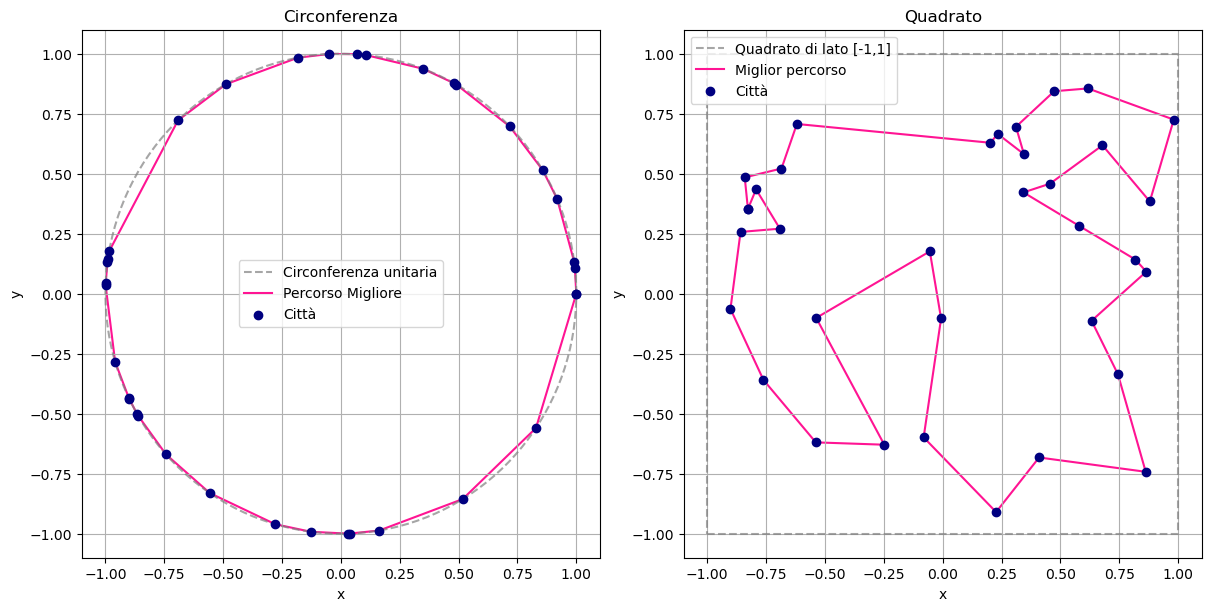

In [28]:
fig, spl = plt.subplots(1, 2, figsize=(12,6), layout = 'constrained') #due grafici affiancati

#Carico la posizione delle città sul cerchio e sul quadrato
finp4 = dinp + 'citta_C_' + str(miglior_continente_C) + estensione_file
citta_C = np.loadtxt(finp4, skiprows=1, usecols=(1,2)) #salto la prima riga e leggo solo la seconda e la terza colonna
finp5 = dinp + 'citta_Q_' + str(miglior_continente_Q) + estensione_file
citta_Q = np.loadtxt(finp5, skiprows=1, usecols=(1,2))

migliore_C = dinp + 'migliore_C_' + str(miglior_continente_C) + estensione_file
migliore_Q = dinp + 'migliore_Q_' + str(miglior_continente_Q) + estensione_file

# Leggi la sequenza del percorso migliore
with open(migliore_C) as f:
    lines = f.readlines()
    # Trova la riga con la sequenza delle città
    for line in lines:
        if line.strip() and not line.startswith('#'):  #esegue solo se la riga non è vuota e non è un commento
            percorso = [int(i)-1 for i in line.split()] #Estrae una lista di interi da una riga, convertendoli in indici zero-based, pronti per essere usati in array Python.

#Visito le città nel giusto ordine
ordine_citta = citta_C[percorso]
ordine_citta = np.vstack([ordine_citta, ordine_citta[0]])  #"impilo" la prima dopo l'ultima e chiudo il percorso

theta = np.linspace(0,2*np.pi, 300)
spl[0].plot(np.cos(theta), np.sin(theta), color ='gray', alpha = 0.7, linestyle = '--', label = 'Circonferenza unitaria')
spl[0].plot(ordine_citta[:,0], ordine_citta[:,1], linestyle='-', color = 'deeppink', zorder = 1, label = 'Percorso Migliore')
spl[0].scatter(ordine_citta[:,0], ordine_citta[:,1], color='navy', marker='o', zorder = 2, label = 'Città') #per grafico a dispersione: città come pallini
spl[0].set_title('Circonferenza')
spl[0].set_xlabel('x')
spl[0].set_ylabel('y')
spl[0].legend()
spl[0].grid(True)

# Leggi la sequenza del percorso migliore
with open(migliore_Q) as f:
    lines = f.readlines()
    # Trova la riga con la sequenza delle città
    for line in lines:
        if line.strip() and not line.startswith('#'):  #esegue solo se la riga non è vuota e non è un commento
            percorso = [int(i)-1 for i in line.split()] #Estrae una lista di interi da una riga, convertendoli in indici zero-based, pronti per essere usati in array Python.

#Visito le città nel giusto ordine
ordine_citta = citta_Q[percorso]
ordine_citta = np.vstack([ordine_citta, ordine_citta[0]])  #"impilo" la prima dopo l'ultima e chiudo il percorso

square_x = [-1, 1, 1, -1, -1]
square_y = [-1, -1, 1, 1, -1]
spl[1].plot(square_x, square_y, color ='gray', alpha = 0.7, linestyle = '--', label = 'Quadrato di lato [-1,1]')
spl[1].plot(ordine_citta[:,0], ordine_citta[:,1], linestyle='-', color = 'deeppink', zorder = 1, label = 'Miglior percorso')
spl[1].scatter(ordine_citta[:,0], ordine_citta[:,1], color='navy', marker='o', zorder = 2, label = 'Città') #per grafico a dispersione: città come pallini
spl[1].set_title('Quadrato')
spl[1].set_xlabel('x')
spl[1].set_ylabel('y')
spl[1].legend()
spl[1].grid(True)

plt.show()


### <span style="color:royalblue">Esercizio 10.2
Ora si applica l'algoritmo genetico ai capoluoghi di provincia italiani. Utilizzo quindi $110$ città o geni al posto dei $34$ utilizzati per cerchio e quadrato e modifico i parametri come segue:
- numero di individui = $1000$ (nel caso seriale il numero di individui viene moltiplicato per il numero di processi per favorire il confronto)
- numero di generazioni = $2000$
- $N_{migr} = 20 $
- probabilità di mutazione = $0.1$
- probabilità di crossover = $0.7$
- probabilità dell'algoritmo di selezione = $2.0$

In [31]:
# === PARAMETRI ===
dinp_serial = "10.1/OUTPUT_SERIAL/"

prefisso_file = "popolazione_I_"
estensione_file = ".dat"

#Trovo il migliore percorso parallelo
df_I_ = {}
for i in range(0, 6):
    finp = dinp + prefisso_file + f'{i}' + estensione_file
    try:
        df_I_[f'{i}'] = pd.read_csv(finp, sep='\\s+', comment='#', names=['GENERAZIONE:','INDIVIDUO:','FITNESS:'])
    except FileNotFound:
        print(" file does not exist: " + finp )

#Miglior percorso seriale
finp_serial = dinp_serial + prefisso_file + "0" + estensione_file
df_I_serial = pd.read_csv(finp_serial, sep='\\s+', comment='#', names=['GENERAZIONE:','INDIVIDUO:','FITNESS:'])

#Calcolo la fitness migliore per ogni continente
best_I = []

#Estraggo la fitness migliore in parallelo
for i in range(0,6):
    if f'{i}' in df_I_:
        best_fitness = df_I_[f'{i}'].sort_values(by='FITNESS:')['FITNESS:'].iloc[0] #iloc[0] seleziona il primo elemento in base alla posizione
        best_I.append(best_fitness)
    else:
        best_I.append(None)

#fitness migliore seriale
best_fitness_serial = df_I_serial.sort_values(by = ['FITNESS:']).head(1)
fitness_value_serial = best_fitness_serial['FITNESS:'].values[0]

#Stampo la fitness migliore per ciascun continente
stampa_best_per_continente(best_I, "Capoluoghi di provincia")

#Stampo la fitness migliore tra tutti i continenti
miglior_continente_I = trova_miglior_continente(best_I, "Capoluoghi di provincia")
print("Fitness migliore con calcolo seriale: " + str(fitness_value_serial))



Capoluoghi di provincia
Continent 0: 57.7113
Continent 1: 57.7113
Continent 2: 57.7113
Continent 3: 57.9529
Continent 4: 57.9529
Continent 5: 57.9529
Continente con fitness minore (geometria Capoluoghi di provincia): Continent 0 con valore: 57.7113
Fitness migliore con calcolo seriale: 60.3237


Le simulazioni sono state effettuate utilizzando lo stesso numero di individui nel caso parallelo e in quello seriale.
Quindi, osservando i risultati, si può facilmente notare che il calcolo parallelo porta a risultati migliori rispetto al calcolo seriale. 

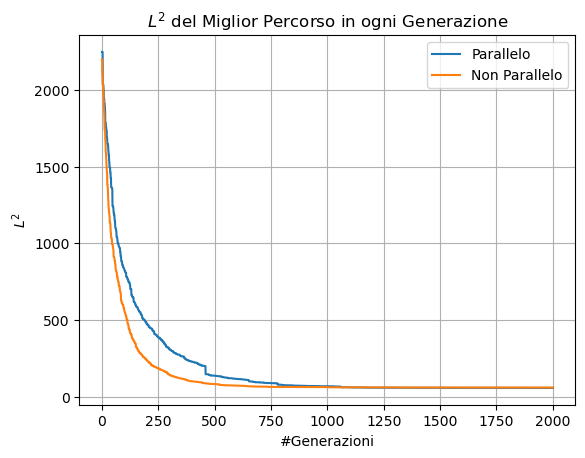

In [32]:

finp1 = dinp + prefisso_file + str(miglior_continente_I) + estensione_file
finp2 = dinp_serial + prefisso_file + "0" + estensione_file

if not os.path.isfile(finp1):
    sys.exit( "file does not exist: " + finp1 )

if not os.path.isfile(finp2):
    sys.exit( "file does not exist: " + finp2 )

df_pop_I = pd.read_csv(finp1, sep='\\s+', comment='#', names=['GENERAZIONE:','INDIVIDUO:','FITNESS:'])
df_best_I = df_pop_I[df_pop_I['INDIVIDUO:']==1]#scelgo i primi individui di ogni generazione

df_pop_I_serial = pd.read_csv(finp2, sep='\\s+', comment='#', names=['GENERAZIONE:','INDIVIDUO:','FITNESS:'])
df_best_I_serial = df_pop_I_serial[df_pop_I_serial['INDIVIDUO:']==1]#scelgo i primi individui di ogni generazione

#plt.figure()
plt.plot(df_best_I['GENERAZIONE:'], df_best_I['FITNESS:'], label = 'Parallelo')
plt.plot(df_best_I_serial['GENERAZIONE:'], df_best_I_serial['FITNESS:'], label = 'Non Parallelo')
plt.xlabel('#Generazioni')
plt.ylabel(r'$L^{2}$')
plt.title(r'$L^{2}$ del Miglior Percorso in ogni Generazione')
plt.grid(True)

plt.legend()
plt.show()

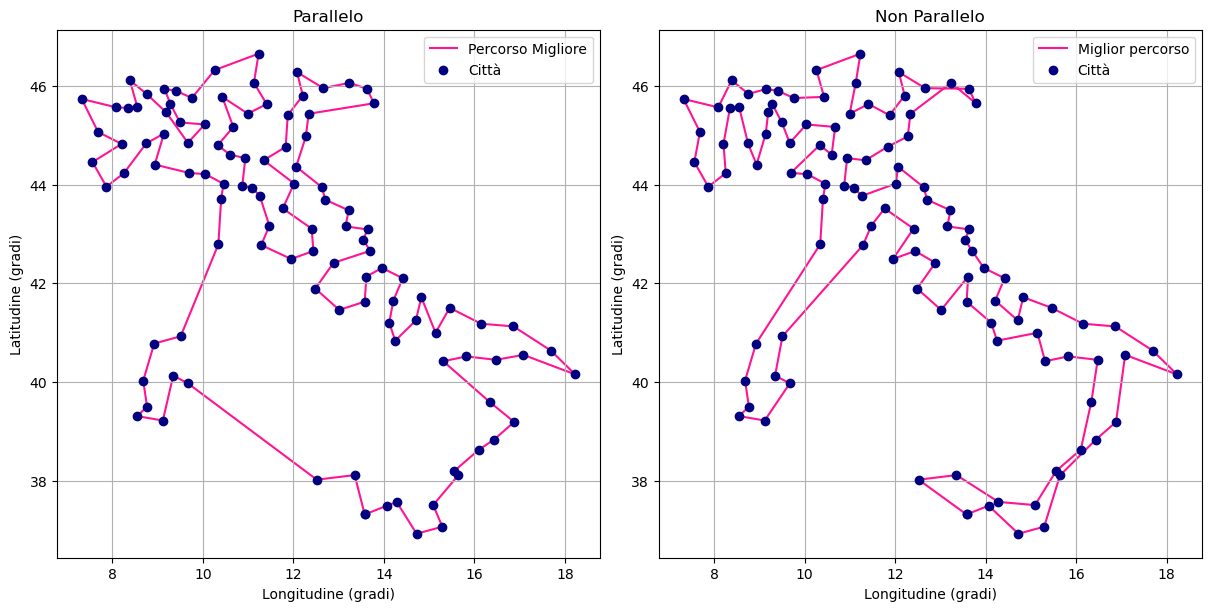

In [33]:
fig, spl = plt.subplots(1, 2, figsize=(12,6), layout = 'constrained') #due grafici affiancati

f_citta = "10.1/INPUT/cap_prov_ita.dat"

citta_I = np.loadtxt(f_citta, usecols=(0,1)) #salto la prima riga e leggo solo la seconda e la terza colonna

migliore_I = dinp + 'migliore_I_' + str(miglior_continente_I) + estensione_file
migliore_I_serial = dinp_serial + 'migliore_I_0' + estensione_file

# Leggi la sequenza del percorso migliore
with open(migliore_I) as f:
    lines = f.readlines()
    # Trova la riga con la sequenza delle città
    for line in lines:
        if line.strip() and not line.startswith('#'):  #esegue solo se la riga non è vuota e non è un commento
            percorso = [int(i)-1 for i in line.split()] #Estrae una lista di interi da una riga, convertendoli in indici zero-based, pronti per essere usati in array Python.

#Visito le città nel giusto ordine
ordine_citta_I = citta_I[percorso]
ordine_citta_I = np.vstack([ordine_citta_I, ordine_citta_I[0]])  #"impilo" la prima dopo l'ultima e chiudo il percorso

# Leggi la sequenza del percorso migliore
with open(migliore_I_serial) as f:
    lines = f.readlines()
    # Trova la riga con la sequenza delle città
    for line in lines:
        if line.strip() and not line.startswith('#'):  #esegue solo se la riga non è vuota e non è un commento
            percorso = [int(i)-1 for i in line.split()] #Estrae una lista di interi da una riga, convertendoli in indici zero-based, pronti per essere usati in array Python.

#Visito le città nel giusto ordine
ordine_citta_I_serial = citta_I[percorso]
ordine_citta_I_serial = np.vstack([ordine_citta_I_serial, ordine_citta_I_serial[0]])  #"impilo" la prima dopo l'ultima e chiudo il percorso

spl[0].plot(ordine_citta_I[:,0], ordine_citta_I[:,1], linestyle='-', color = 'deeppink', zorder = 1, label = 'Percorso Migliore')
spl[0].scatter(ordine_citta_I[:,0], ordine_citta_I[:,1], color='navy', marker='o', zorder = 2, label = 'Città') #per grafico a dispersione: città come pallini
spl[0].set_title('Parallelo')
spl[0].set_xlabel('Longitudine (gradi)')
spl[0].set_ylabel('Latitudine (gradi)')
spl[0].legend()
spl[0].grid(True)

spl[1].plot(ordine_citta_I_serial[:,0], ordine_citta_I_serial[:,1], linestyle='-', color = 'deeppink', zorder = 1, label = 'Miglior percorso')
spl[1].scatter(ordine_citta_I_serial[:,0], ordine_citta_I_serial[:,1], color='navy', marker='o', zorder = 2, label = 'Città') #per grafico a dispersione: città come pallini
spl[1].set_title('Non Parallelo')
spl[1].set_xlabel('Longitudine (gradi)')
spl[1].set_ylabel('Latitudine (gradi)')
spl[1].legend()
spl[1].grid(True)

plt.show()
